## Notes: 
line of thinking
documented motivation
understand what er are doing


proprocess 3 subjects and provide/document the cleaning times / bad channels, document the bad components

- Preprocessing Filtering, re-referencening, ICA
- Data cleaning: Time, channel and subjects
- ERP peak analysis Extract the study-relevant ERP peak subjectwise (e.g. one value per subject) and statistically test them. RQ: On which ERP-peaks do we find major difference between the conditions?
- Time Frequency analysis Calculate an induced time-frequency analysis of the main experimental contrast RQ: What oscillations underley our effect of interest?
- either:	- Mass Univariate Use a multiple regression of the main experimental contrast, controlling for reaction time (you need to calculate RT yourself). RQ: When/Where do we find differences between our conditions? Is there an influence of reaction time?
		OR
		- Decoding analysis Decode the main contrast of the experiment across time RQ: When is information about the conditions in our data available?

## Dataset Summary and Exploration
P300: A visual oddball experiment with a prolonged effect at 300ms.

In [23]:
"""
import libraries
"""
import mne
import ccs_eeg_utils
from mne_bids import (BIDSPath,read_raw_bids)
import matplotlib.pyplot as plt
import matplotlib
import os # make dir


# silent mode but doesnt work
#matplotlib.use('Agg')
#%matplotlib inline

from matplotlib.pyplot import figure

import numpy as np

In [38]:
def plot_each_channel(num_channels, subject_id):
    """
    plot raw data of each channel
    """
    # create dir to save plots if not existent
    if not os.path.exists('./results/raw_channel_data'):
        os.makedirs('./results/raw_channel_data')
    
    # Extract a single channel and plot the whole timeseries.
    for channel_number in range(1,num_channels):#1

        num_samples_in_channel = len(raw[channel_number][0][0])
        #print('samples in channel:',num_samples_in_channel)
        time = (raw[channel_number,0:num_samples_in_channel][0][0])
        channel = (raw[channel_number,0:num_samples_in_channel][1])
        fig=plt.figure(figsize=(12,8), dpi= 200, facecolor='w', edgecolor='k')

        plt.plot(channel,time)
        plt.ylabel('potential [µV]')
        plt.xlabel('time [ms]')
        plt.savefig('./results/raw_channel_data/sub'+str(subject_id)+'_channel'+str(channel_number)+'.png')
        #plt.show()
        plt.close(fig) # don't display figure

        
        """
        plots are saved in ./results/raw_channel_data')
        """

In [17]:
def add_events(raw):
    """
    add events
    """
    evts,evts_dict = mne.events_from_annotations(raw)

    # get all keys which contain "stimulus"
    wanted_keys = [e for e in evts_dict.keys() if "stimulus" in e]    # subset the large event-dictionairy
    
    evts_dict_stim=dict((k, evts_dict[k]) for k in wanted_keys if k in evts_dict)

In [42]:
def band_pass_filtering(raw, subject_id):
    """
    applys the firwin banpassfilter between 0.1 and 54 hz
    """

    # plot raw data before band-pass filtering
    raw.plot_psd(area_mode='range', tmax=10.0, average=False,xscale="linear",)
    
    # create dir to save plots if not existent
    if not os.path.exists('./results/before_filtering'):
        os.makedirs('./results/before_filtering')
    
    #save plot
    plt.savefig('./results/before_filtering/sub'+str(subject_id)+'.png')
    plt.close() # don't display figure

    """
    band-pass filter between 0.1 Hz and 50 Hz, because Acunzo et al., 2012 recommended highp-pass <=1Hz and >40Hz and FIR. 0.75 (mildly) reduces P3 response amplitude
    59 to remove power line atifacts which are at 60 Hz
    """
    # apply filter
    raw_f = raw.copy().filter(0.1,54, fir_design='firwin')

    # plot data
    raw_f.plot_psd(area_mode='range', tmax=10.0, average=False,xscale="log")
    
    # save plots
    if not os.path.exists('./results/after_filtering'): # create dir to save plots if not existent
        os.makedirs('./results/after_filtering')
    plt.savefig('./results/after_filtering/sub'+str(subject_id)+'.png') #save plot
    plt.close() # don't display figure

    return raw_f
    """
    The Filter seems to work as intended, as the power decreases at after 54 Hz.
    """

In [55]:
"""
pipeline

load data
read annotations
resample to 256 Hz
re-reference to P9 and P10
(Extract a single channel and plot the whole timeseries)
"""
# path where to save the datasets.
bids_root = "../local/bids"
num_subjects = 1#37
num_channels = 33

for subject in range(1,num_subjects+1):
    subject_id = f"{subject:03}"

    bids_path = BIDSPath(subject=subject_id,task="P3",session="P3",
                         datatype='eeg', suffix='eeg',
                         root=bids_root)

    # read the file
    raw = read_raw_bids(bids_path)
        
    # plot each channel
    # plot_each_channel(num_channels, subject_id) # takes a while

    # fix the annotations readin
    ccs_eeg_utils.read_annotations_core(bids_path,raw)
    
    # load data
    raw.load_data()
    
    # add events
    add_events(raw)
     
    # delay shift
    # todo
   
    # resample / downsample frequency
    raw_f.resample(256, npad="auto")  # set sampling frequency to 256 Hz as in Kappenman et al. 
    
    # rerefernecing to P9 and P10 becuase Kappenman et al. says 
    # "we find that P9 and P10 provide cleaner signals than the traditional mastoid sites"
    raw_f.set_eeg_reference(ref_channels=['P9', 'P10'], verbose=None) 
    
    # add channel locations
    raw.set_montage('standard_1020',match_case=False)
    
    # band pass filtering between 0.1 and 54 hz
    raw_f = band_pass_filtering(raw, subject_id)
    
    """TODO: remove large muscle artifacts, extreme voltage offsets, 
    or break periods longer than two seconds"""
    
    # ICA
    ICA(raw_f)




Reading ../local/bids/sub-001/ses-P3/eeg/sub-001_ses-P3_task-P3_eeg.fdt
Reading events from ../local/bids/sub-001/ses-P3/eeg/sub-001_ses-P3_task-P3_events.tsv.
Reading channel info from ../local/bids/sub-001/ses-P3/eeg/sub-001_ses-P3_task-P3_channels.tsv.
Reading 0 ... 478207  =      0.000 ...   466.999 secs...


<ipython-input-55-e61daea65306>:23: RuntimeWarning: Data file name in EEG.data (sub-001_task-P3_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-001_ses-P3_task-P3_eeg.fdt).
  raw = read_raw_bids(bids_path)
<ipython-input-55-e61daea65306>:23: RuntimeWarning: Did not find any coordsystem.json associated with sub-001_ses-P3_task-P3.

The search_str was "../local/bids/sub-001/**/sub-001_ses-P3*coordsystem.json"
  raw = read_raw_bids(bids_path)


Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Effective window size : 2.000 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 54 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 54.00 Hz


/home/chrei/venv/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Fitting ICA took 81.7s.


**Q:** What is the unit/scale of the data?
**A:** Electric potential in [µV] and time in [ms]

**T:** Have a look at `raw.info` and note down what the sampling frequency is (how many EEG-samples per second)

In [56]:
raw.info

<Info | 10 non-empty values
 bads: []
 ch_names: FP1, F3, F7, FC3, C3, C5, P3, P7, P9, PO7, PO3, O1, Oz, Pz, CPz, ...
 chs: 30 EEG, 3 EOG
 custom_ref_applied: False
 dig: 33 items (3 Cardinal, 30 EEG)
 highpass: 0.0 Hz
 line_freq: 60
 lowpass: 512.0 Hz
 meas_date: unspecified
 nchan: 33
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 4 items (dict)
>

## Epoching 
Choosing Pz for P3 because this is the site most widely used in the literature and recommended by Kappenman et al.
Cut the raw data to one channel using `raw.pick_channels(["Pz"])` - note that this will permanently change the "raw" object and "deletes" alle other channels from memory. If you want rather a copy you could use `raw_subselect = raw.copy().pick_channels(["Pz"]))`.

<RawEEGLAB | sub-001_ses-P3_task-P3_eeg.fdt, 1 x 478208 (467.0 s), ~3.7 MB, data loaded>


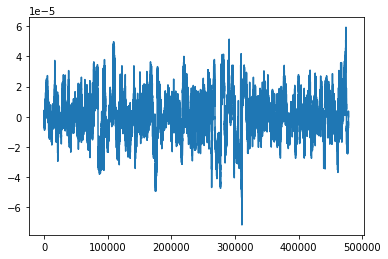

In [8]:
raw_f.pick_channels(["Pz"])
print(raw_f)
plt.plot(raw_f[:,:][0].T)

In [9]:
raw_f.info

<Info | 10 non-empty values
 bads: []
 ch_names: Pz
 chs: 1 EEG
 custom_ref_applied: False
 dig: 33 items (3 Cardinal, 30 EEG)
 highpass: 0.1 Hz
 line_freq: 60
 lowpass: 54.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 1024.0 Hz
 subject_info: 4 items (dict)
>

In [10]:
raw_f.annotations
# These values reflect the values in the bids `*_events.tsv`  file.

<Annotations | 402 segments: response:201 (195), response:202 (7), ...>

sub-002_task-P3_events.tsv file:

| onset   | duration | sample | trial    | stim_file | value |
|---------|----------|--------|----------|-----------|-------|
| 11.9561 | 0.0      | 12244  | response | n/a       | 202   |
| 13.9639 | 0.0      | 14300  | response | n/a       | 202   |
| 18.3779 | 0.2      | 18820  | stimulus | n/a       | 45    |
| ...     | ...      | ...    | ...      | ...       | ...   |

**T:** MNE-speciality: Convert annotations to events with `evts,evts_dict = mne.events_from_annotations(raw)`. Have a look at evts - it shows you the sample, the duration and event-id (with the look-up table evts_dict). In this case we only want to look at stimulus evoked responses, so we subset the event table (note: this could be done after epoching too)

In [11]:
"""
Epoch the data 
"""
epochs = mne.Epochs(raw_f,evts,evts_dict_stim,tmin=-0.2,tmax=0.8) # tmin and tmax chosen as recommended by Kappenman et al.
epochs

NameError: name 'evts' is not defined

In [ ]:
epochs.average().plot()

In [ ]:
# Plot all trials
plt.plot(np.squeeze(epochs.get_data()[:,0,:].T))

Now index the epochs `evoked = epochs[index].average()` and average them. You can then plot them either via `evoked.plot()` or with `mne.viz.plot_compare_evokeds([evokedA,evokedB])`.

In [ ]:
# indexing and averaging epochs
target = epochs[["stimulus:{}{}".format(k,k) for k in [1,2,3,4,5]]].average()
distractor = epochs[["stimulus:{}{}".format(k,j) for k in [1,2,3,4,5] for j in [1,2,3,4,5] if k!=j]].average()

# plotting
mne.viz.plot_compare_evokeds([target,distractor])

**Q** What is the unit/scale of the data now? Set it into context to the other two scales you reported (**Q**'s higher up). 

20µV. So we went from 20.000µV to 100µV to 20µV


## Cleaning Data

In [ ]:
"""
exercise 3 but is it necessary?
"""

# ICA

In [63]:
ICA(raw_f)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting all PCA components: 30 components
Fitting ICA took 32.0s.


In [99]:
def ICA(raw_f):
    # set sampling frequency to 2 Hz as suggested on Pipeline slide to speed up ICA calculation
    # raw_f.resample(100, npad="auto") # not sure if needed
    
    # Generate an ICA object 
    ica = mne.preprocessing.ICA(method="fastica")

    # fit the ICA on the data
    ica.fit(raw_f,verbose=True)

    # plot components
    ica.plot_components(picks=range(30))    
    save_plot('ICA_components', subject_id)
    
    # plot properties
    # create dir to save plots if not existent
    if not os.path.exists('./results/ICA_properties'): 
        os.makedirs('./results/ICA_properties')
    for component in range(ica.n_components_):
        ica.plot_properties(raw_f,picks=component,psd_args={'fmax': 35.},reject=None)
        # save plot    
        plt.savefig('./results/ICA_properties/sub'+str(subject_id)+'component'+str(component)+'.png')
        # don't display figure
        plt.close()

In [101]:
ICA(raw_f)

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting all PCA components: 30 components
Fitting ICA took 28.8s.
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
233 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
Not setting metadata
233 matching events found
No baseline correction applied
0 projection items ac

In [ ]:
heartbeat_artefacts = []
blink_artefacts = []
eye_movement_artefacts = []
muscle_artefacts = [] # often non-stationary activity, small ERPs, "square-root spectrum", one electrode?, Yaw, below/behind ear, lowwe back of the head
other_artefacts = []
# brain components ideally show strong and clear ERPs, activity stationary over whole experiment, powerspectrum including alpha/beta peak at ~10hz, 

exclude = []
exclude.extend(heartbeat_artefacts)
exclude.extend(blink_artefacts)
exclude.extend(eye_movement_artefacts)
exclude.extend(muscle_artefacts)
exclude.extend(other_artefacts)
ica.exclude = exclude

In [46]:
evts,evts_dict = mne.events_from_annotations(raw_f)
wanted_keys = [e for e in evts_dict.keys() if "response" in e]
evts_dict_stim=dict((k, evts_dict[k]) for k in wanted_keys if k in evts_dict)

Used Annotations descriptions: ['response:201', 'response:202', 'stimulus:11', 'stimulus:12', 'stimulus:13', 'stimulus:14', 'stimulus:15', 'stimulus:21', 'stimulus:22', 'stimulus:23', 'stimulus:24', 'stimulus:25', 'stimulus:31', 'stimulus:32', 'stimulus:33', 'stimulus:34', 'stimulus:35', 'stimulus:41', 'stimulus:42', 'stimulus:43', 'stimulus:44', 'stimulus:45', 'stimulus:51', 'stimulus:52', 'stimulus:53', 'stimulus:54', 'stimulus:55']


In [93]:
"""
before ICA
"""
epochs = mne.Epochs(ica.get_sources(raw_f),evts,evts_dict_stim,tmin=-0.2,tmax=0.8)
epochs.average(picks=13).plot() # 13 for Pz?
save_plot('Pz_before_ICA', subject_id)


Not setting metadata
Not setting metadata
202 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [96]:
"""
after ICA
"""
epochs = mne.Epochs(raw_f,evts,evts_dict_stim,tmin=-0.2,tmax=0.8)
epochs.average().plot(picks='Pz')
save_plot('Pz_after_ICA', subject_id)


Not setting metadata
Not setting metadata
202 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Need more than one channel to make topography for eeg. Disabling interactivity.


Transforming to ICA space (30 components)
Zeroing out 3 ICA components
Transforming to ICA space (30 components)
Zeroing out 0 ICA components


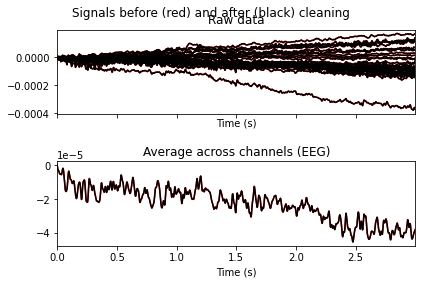

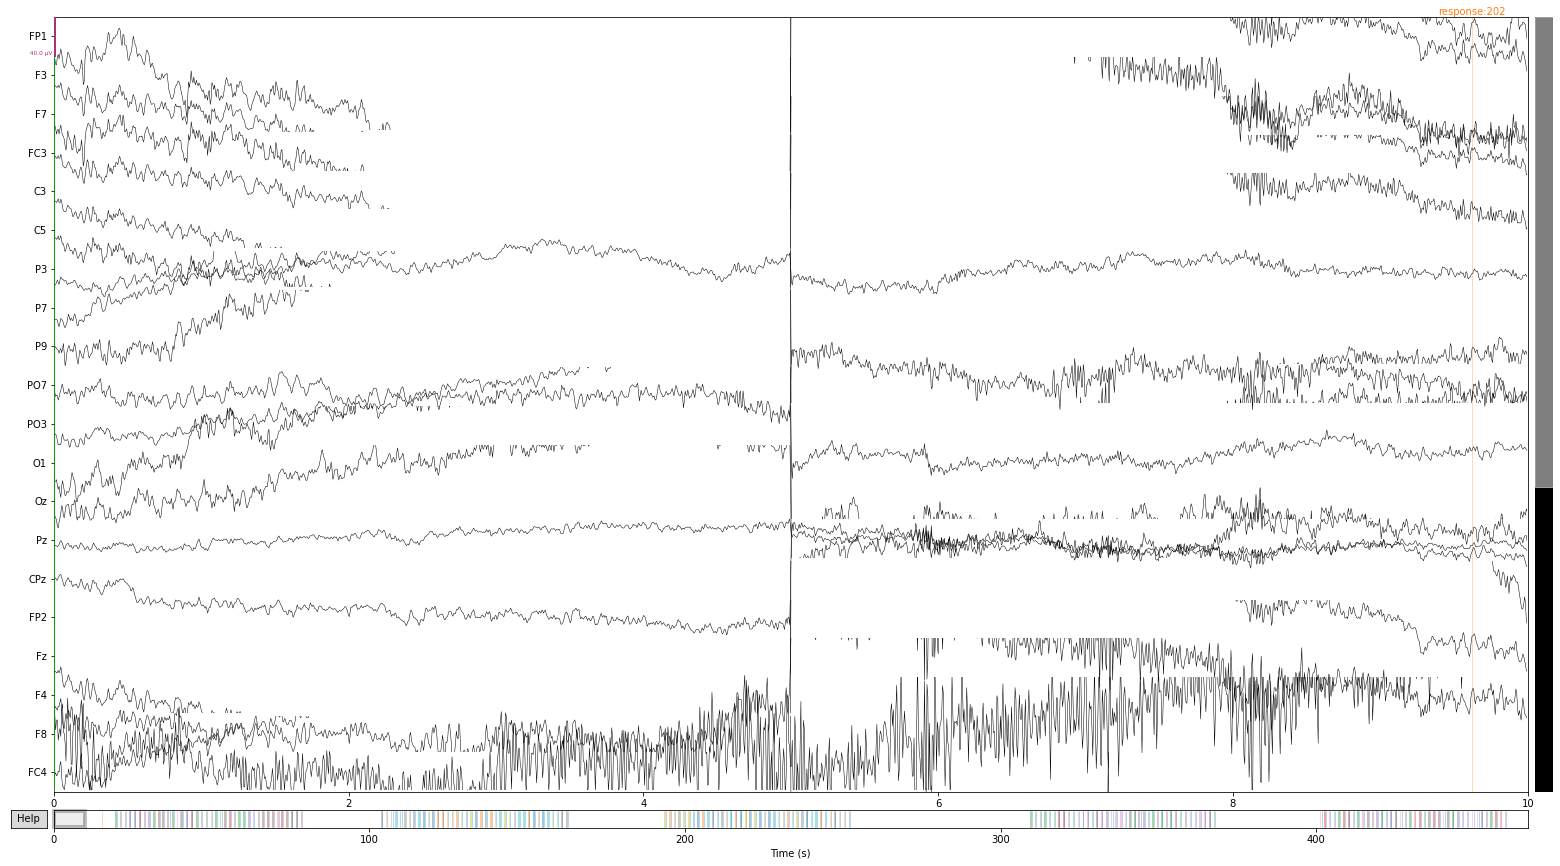

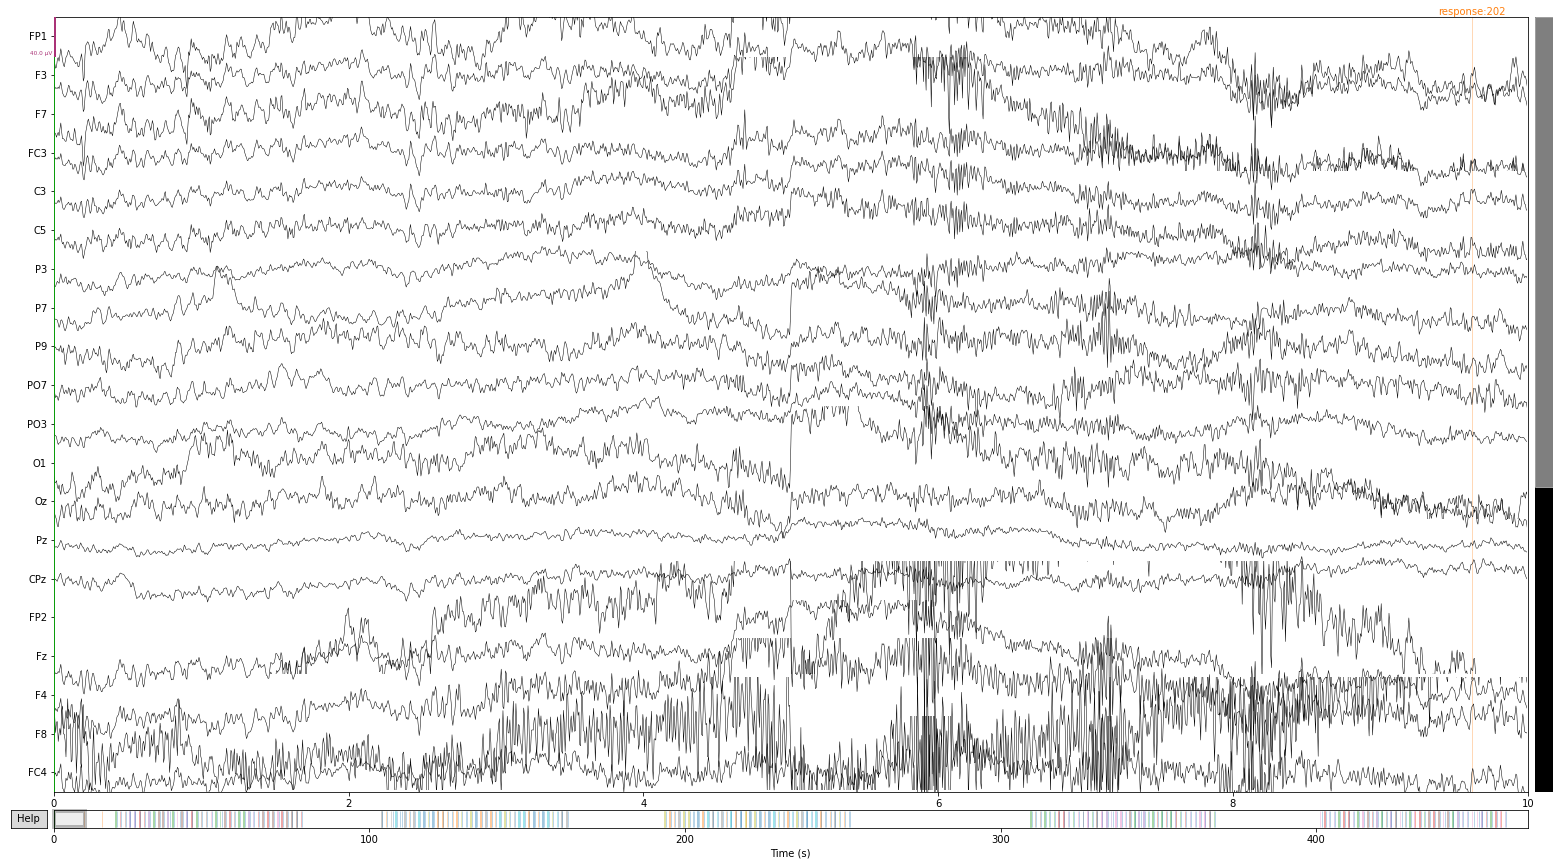

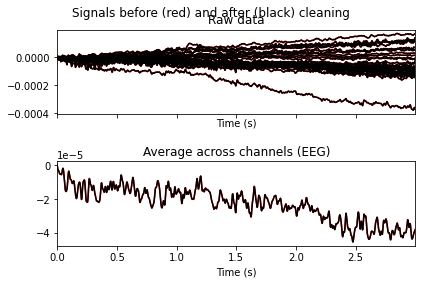

In [98]:
reconst_raw_f = raw_f.copy()
ica.apply(reconst_raw_f,exclude=[1,8,9])

raw_f.plot()
reconst_raw_f.plot()  
ica.plot_overlay(raw_f)#,exclude=[1,8,9]